# 30-Day Readmission - Decision Tree (Use Capstone Server)

**Goal.** Predict 30-day readmission (binary) on NRD encounters.

**Data hygiene.**
- Split by `nrd_visitlink` to avoid patient leakage (`GroupKFold/GroupShuffleSplit`).
- One-hot encode categorical fields with `get_dummies` (train-fit, then align test columns).

**Model.** `DecisionTreeClassifier` (tuned on depth/leaf/impurity), class imbalance checked (option to use `class_weight='balanced'`).

**Evaluation.**
- ROC-AUC (primary), PR curve + Average Precision (imbalanced data), confusion matrix at a chosen threshold.
- Threshold chosen by business rule (e.g., recall ≥ 0.80) or Youden’s J.

**Explainability.**
- Feature importances (top N) and shallow tree plot for interpretability.

### (1) Load Libraries

In [2]:
import pyarrow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import randint, uniform

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, PrecisionRecallDisplay, average_precision_score
#from sklearn.tree import plot_tree

ImportError: cannot import name 'RocCurveDisplay' from 'sklearn.metrics' (/opt/conda/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

### (2) Load the data

In [3]:
# Load Da Data
df = pd.read_parquet('../data/nrd_preprocessed_updated.parquet')
#df.dtypes

### (3) Define target/ID, make X/y/groups, quick class balance

In [4]:
target, id_col = 'readmitted_30_days', 'nrd_visitlink'
df[id_col] = df[id_col].astype(str)
df[target] = df[target].astype(int)

X = df.drop(columns=[target, id_col])
y = df[target].to_numpy()


groups = df[id_col].to_numpy()

print("Pos rate:", y.mean().round(3))

Pos rate: 0.14


### (4) Group-aware Splitting Training and Testing Data

In [5]:
# Group-aware split to avoid leakage across the same patient

gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train = X.iloc[train_idx].copy()
X_test  = X.iloc[test_idx].copy()
y_train = y[train_idx]
y_test  = y[test_idx]

groups_train = pd.factorize(groups[train_idx])[0]
groups_test  = pd.factorize(groups[test_idx])[0]



In [6]:
# Reduce memory usage for numerical datatypes
num_cols = X_train.select_dtypes(include=['float64','float32','int64','int32']).columns
X_train[num_cols] = X_train[num_cols].apply(pd.to_numeric, downcast='float')
X_test[num_cols]  = X_test[num_cols].apply(pd.to_numeric, downcast='float')

y_train = y_train.astype('int8')
y_test  = y_test.astype('int8')

### (5) One-hot encode selected categoricals

In [7]:
# Which columns to OHE
#df.nunique()

In [8]:
# 1) Columns to one hot encode.
cols_ohe = ['mdc','hcup_ed','i10_serviceline','pay1','pclass_orproc','resident','hosp_ur_teach','h_contrl','los_group','aprdrg']

# 2) Build dummy columns
X_train = pd.get_dummies(X_train, columns=cols_ohe, drop_first=False, dtype='uint8')
X_test  = pd.get_dummies(X_test,  columns=cols_ohe, drop_first=False, dtype='uint8')

# 3) Avoid leaking by removing test-only levels
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [9]:
print(X_train.shape[0],X_test.shape[0]) 
print(X_test.shape[0]/(X_train.shape[0]+X_test.shape[0])*100)

1478770 492839
24.99679196027204


### (6) PCA Analysis, Factor Reduction (Not Used)

In [10]:
scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_scaled = scaler.fit_transform(X_train)
Xte_scaled = scaler.transform(X_test)

pca = PCA()
pca.fit(Xtr_scaled)
evr = pca.explained_variance_ratio_

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float32, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Scree PLots

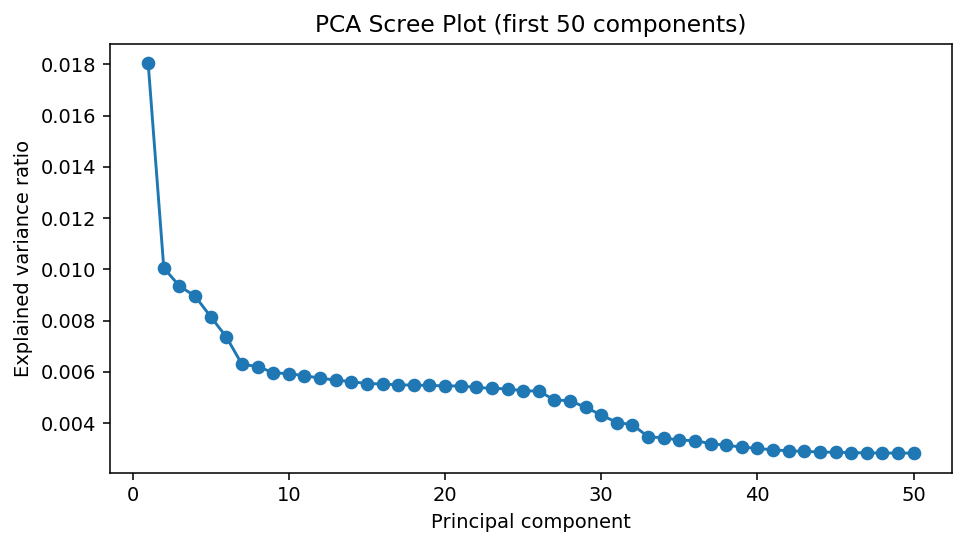

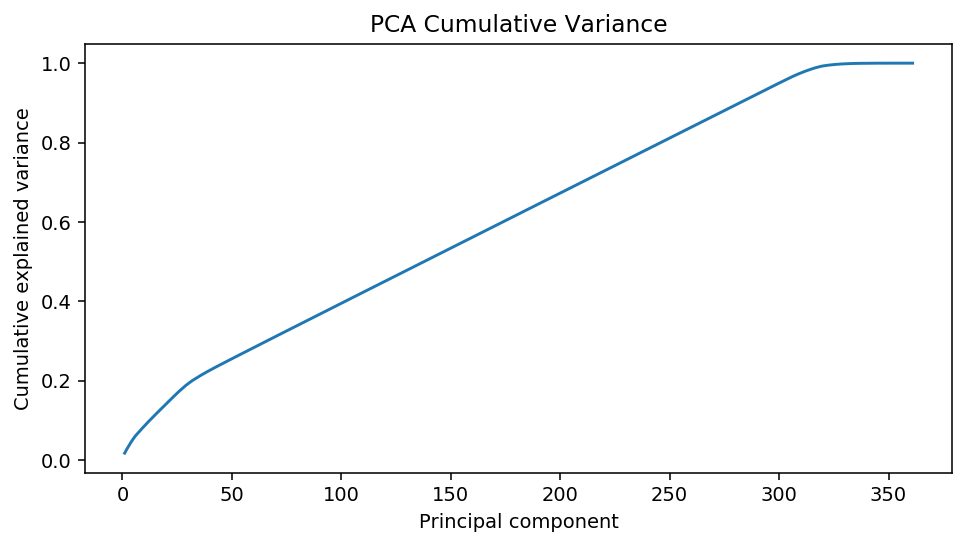

In [11]:
k = min(50, evr.size)  # show first 30 components max

plt.figure(figsize=(7,4), dpi=140)
plt.plot(np.arange(1, k+1), evr[:k], marker='o')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('PCA Scree Plot (first {} components)'.format(k))
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4), dpi=140)
plt.plot(np.arange(1, evr.size+1), np.cumsum(evr))
plt.xlabel('Principal component')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Cumulative Variance')
plt.tight_layout()
plt.show()

PCA is not used in tree based models, but it is still cool.

### (7) Pipeline

#### Defining Grid

In [12]:
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 8),
    'min_samples_leaf': randint(50, 201),
    'min_samples_split': randint(50, 201),
    'max_features': uniform(0.3, 0.4),
    'class_weight': [None, 'balanced']
}

#### Define Pipeline

In [13]:
rs = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc', 
    cv=GroupKFold(n_splits=3), # changed from 5 to 3 to avoid empty class folds
    n_jobs=-1,
    random_state=42,
    verbose=1
)

#### Run a pipeline

In [14]:
rs.fit(X_train, y_train, groups=groups[train_idx])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished


RandomizedSearchCV(cv=GroupKFold(n_splits=3), error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fba677235f8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fba6772e128>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fba6772e438>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fba6772e080>, 'class_weight': [None, 'balanced']},
          pre_dispatch='2*n_job

#### List Model Performance

In [15]:
cv_df = pd.DataFrame(rs.cv_results_)
cv_df = cv_df.sort_values('mean_test_score', ascending=False)
cv_df[['mean_test_score','param_criterion','param_max_depth','param_min_samples_leaf','param_class_weight']].head(10)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,mean_test_score,param_criterion,param_max_depth,param_min_samples_leaf,param_class_weight
6,0.613560,gini,7,67,None
0,0.611109,entropy,7,121,None
14,0.610375,gini,7,120,None
11,0.609403,entropy,6,97,balanced
15,0.609153,gini,6,112,balanced
12,0.608690,entropy,6,89,balanced
8,0.607942,entropy,6,57,balanced
4,0.607735,gini,6,108,balanced
1,0.604960,entropy,5,137,None
9,0.604908,gini,6,181,balanced


#### Keep Best Model

In [16]:
best_model = rs.best_estimator_

### (8) Results

#### Finding the best probability threshold

In [17]:
proba = best_model.predict_proba(X_test)[:, 1]

ths = np.arange(0.0, 1, 0.05)
rows = []
for t in ths:
    pred = (proba >= t).astype(int)
    cm = confusion_matrix(y_test, pred).astype(float)
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f1   = (2*prec*rec)/(prec+rec) if (prec+rec)>0 else 0.0
    rows.append({
        'threshold': t,
        'precision': prec, 'recall': rec, 'f1': f1,
        'TN%': tn/total, 'FP%': fp/total, 'FN%': fn/total, 'TP%': tp/total
    })

thr_df = pd.DataFrame(rows)

#  thr_df.round(3)

#### Graphical Probability threshold tradeoff

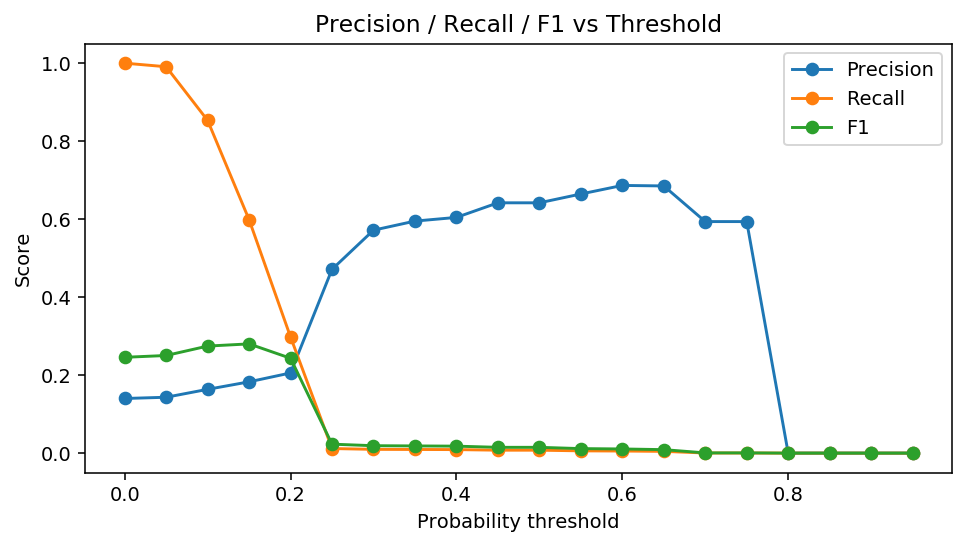

In [18]:
plt.figure(figsize=(7,4), dpi=140)
plt.plot(thr_df['threshold'], thr_df['precision'], marker='o', label='Precision')
plt.plot(thr_df['threshold'], thr_df['recall'],    marker='o', label='Recall')
plt.plot(thr_df['threshold'], thr_df['f1'],        marker='o', label='F1')
plt.xlabel('Probability threshold'); plt.ylabel('Score'); plt.title('Precision / Recall / F1 vs Threshold')
plt.legend(); plt.tight_layout(); plt.show()


#### Confusion matrix

In [19]:
###### UPDATE proba threshold based on graph #############

pred  = (proba >= 0.2).astype(int)
cm = confusion_matrix(y_test, pred)

print(pd.DataFrame(cm, index=['Actual No','Actual Yes'], columns=['Pred No','Pred Yes']))

            Pred No  Pred Yes
Actual No    344365     79446
Actual Yes    48471     20557


#### AUC Result!

In [20]:
print(f"ROC-AUC: {roc_auc_score(y_test, proba):.3f}")

ROC-AUC: 0.614


### (9) Interpretation

#### Most important Features

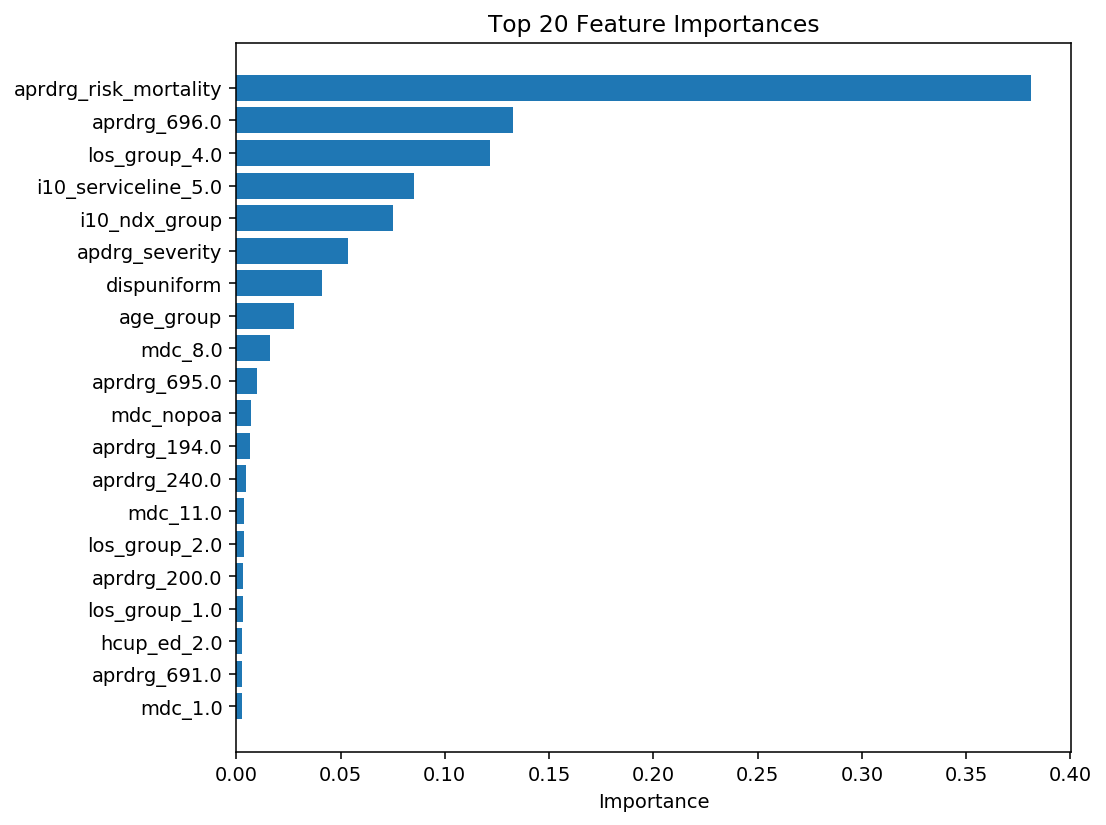

In [21]:
imp = best_model.feature_importances_
names = X_train.columns.to_numpy()
order = np.argsort(imp)[::-1][:20]

plt.figure(figsize=(8,6), dpi=140)
plt.barh(range(len(order)), imp[order][::-1])
plt.yticks(range(len(order)), names[order][::-1])
plt.xlabel('Importance'); plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

#### Tree Viz (Not supported with our sklearn version)

In [22]:
#plt.figure(figsize=(20,8), dpi=150)
#plot_tree(
#    best_model,
#    feature_names=X_train.columns.tolist(),
#    class_names=['No','Yes'],
#    filled=True, rounded=True, impurity=False, proportion=True, fontsize=10,
#    max_depth=3
#)

#plt.title('Decision Tree — Top 3 Layers (deeper nodes hidden)')
#plt.tight_layout(pad=1.2)
#plt.show()


# END of Notebook